In [1]:
import joblib
import os

# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train_svd = pd.read_parquet('00_dataset/with_stopwords/train_features_sw_svd.parquet', engine='fastparquet')
df_test_svd = pd.read_parquet('00_dataset/with_stopwords/test_features_sw_svd.parquet', engine='fastparquet')
df_val_svd = pd.read_parquet('00_dataset/with_stopwords/val_features_sw_svd.parquet', engine='fastparquet')

In [3]:
# Separate into X and y
X_train_svd = df_train_svd.drop(columns=["label"])
y_train_svd = df_train_svd["label"]

In [4]:
X_test_svd = df_test_svd.drop(columns=["label"])
y_test_svd = df_test_svd["label"]

In [5]:
X_val_svd = df_val_svd.drop(columns=["label"])
y_val_svd = df_val_svd["label"]

In [6]:
def train_in_batches(X, y, model, num_batches=10, model_save_prefix='model_batch_'):
    """
    Train a model in a fixed number of batches and save the model after each batch.

    Parameters:
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Labels.
        model: The model to train (e.g., LogisticRegression).
        num_batches (int): Number of batches to split the data into.
        model_save_prefix (str): Prefix for saving model checkpoints.

    Returns:
        Trained model.
    """
    # Calculate the batch size based on the number of batches
    n_samples = len(X)
    batch_size = n_samples // num_batches

    # Find the latest saved model checkpoint
    latest_batch = -1
    for i in range(num_batches):
        checkpoint_path = f'{model_save_prefix}{i}.joblib'
        if os.path.exists(checkpoint_path):
            latest_batch = i

    # Load the latest saved model if it exists
    if latest_batch != -1:
        print(f"Loading model from {model_save_prefix}{latest_batch}.joblib...")
        model = load(f'{model_save_prefix}{latest_batch}.joblib')
        start_batch = latest_batch + 1
    else:
        print("No saved model found. Starting training from scratch...")
        start_batch = 0

    # Train in batches
    for i in range(start_batch, num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size if i < num_batches - 1 else n_samples  # Last batch takes remaining samples

        # Get the current batch
        X_batch = X[start:end]
        y_batch = y[start:end]

        # Train the model on the current batch
        print(f"Training on batch {i + 1}/{num_batches} (samples {start}-{end})...")
        model.partial_fit(X_batch, y_batch, classes=y.unique())

        # Save the model after each batch
        checkpoint_path = f'{model_save_prefix}{i}.joblib'
        dump(model, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")

    print("Training completed!")
    return model

In [ ]:
os.makedirs('00_dataset/with_stopwords/model/sgd_lr_svd', exist_ok=True)

sgd_lr_svd = SGDClassifier(
    loss='log_loss',               # Logistic regression loss
    penalty='l2',             # L2 regularization (similar to saga in LogisticRegression)
    max_iter=1000,            # Maximum number of epochs
    random_state=42,          # Reproducibility
    # learning_rate='optimal',  # Learning rate schedule (default)
    # eta0=0.01                 # Initial learning rate (used if learning_rate='constant')
)

trained_model = train_in_batches(
    X=X_train_svd,
    y=y_train_svd,
    model=sgd_lr_svd,
    num_batches=10,  # Split data into 10 batches
    model_save_prefix='00_dataset/with_stopwords/model/sgd_lr_svd/sgd_lr_svd_batch_'  # Prefix for saving checkpoints
)

In [18]:
# Assuming X_train_svd, X_test_svd, and X_val_svd are pandas DataFrames
columns_to_scale = ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 
                    'question_count', 'uppercase_ratio', 'duplicate_word_count', 
                    'emoji_count', 'avg_word_length']

# Initialize ColumnTransformer with MinMaxScaler
ct_mms = ColumnTransformer(transformers=[('min_max_scaler', MinMaxScaler(), columns_to_scale)], 
                           remainder='passthrough')

# Step 1: Fit the scaler on the training data
ct_mms.fit(X_train_svd)

# Function to maintain column names after transformation
def transform_in_percentage(data, transformer, percentage=10):
    batch_size = max(1, int(len(data) * (percentage / 100)))  # Compute batch size
    transformed_batches = []

    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i + batch_size]  # Preserve DataFrame format
        transformed_batch = transformer.transform(batch)  # Transform batch
        transformed_batches.append(transformed_batch)

    # Convert transformed data back into a DataFrame with original column names
    transformed_array = np.vstack(transformed_batches)
    
    # Get feature names after transformation
    transformed_feature_names = (transformer.get_feature_names_out()  # Get transformed names
                                 if hasattr(transformer, 'get_feature_names_out') 
                                 else columns_to_scale + [col for col in data.columns if col not in columns_to_scale])

    return pd.DataFrame(transformed_array, columns=transformed_feature_names, index=data.index)

# Apply the transformation and maintain column names
X_train_svd_scaled = transform_in_percentage(X_train_svd, ct_mms)
X_test_svd_scaled = transform_in_percentage(X_test_svd, ct_mms)
X_val_svd_scaled = transform_in_percentage(X_val_svd, ct_mms)

In [19]:
joblib.dump(X_train_svd_scaled, '00_dataset/with_stopwords/data/X_train_svd_scaled.joblib')
joblib.dump(X_test_svd_scaled, '00_dataset/with_stopwords/data/X_test_svd_scaled.joblib')
joblib.dump(X_val_svd_scaled, '00_dataset/with_stopwords/data/X_val_svd_scaled.joblib')

['00_dataset/with_stopwords/data/X_val_svd_scaled.joblib']

In [20]:
os.makedirs('00_dataset/with_stopwords/model/sgd_lr_svd_scaled', exist_ok=True)

sgd_lr_svd_scaled = SGDClassifier(
    loss='log_loss',               # Logistic regression loss
    penalty='l2',             # L2 regularization (similar to saga in LogisticRegression)
    max_iter=1000,            # Maximum number of epochs
    random_state=42,          # Reproducibility
    # learning_rate='optimal',  # Learning rate schedule (default)
    # eta0=0.01                 # Initial learning rate (used if learning_rate='constant')
)

trained_model_scaled = train_in_batches(
    X=X_train_svd_scaled,
    y=y_train_svd,
    model=sgd_lr_svd_scaled,
    num_batches=10,  # Split data into 10 batches
    model_save_prefix='00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_'  # Prefix for saving checkpoints
)

No saved model found. Starting training from scratch...
Training on batch 1/10 (samples 0-42592)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_0.joblib
Training on batch 2/10 (samples 42592-85184)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_1.joblib
Training on batch 3/10 (samples 85184-127776)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_2.joblib
Training on batch 4/10 (samples 127776-170368)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_3.joblib
Training on batch 5/10 (samples 170368-212960)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_4.joblib
Training on batch 6/10 (samples 212960-255552)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_5.joblib
Training on batch 7/10 (samples 255552-298144)...
Model saved to 

In [7]:
X_train_svd_scaled_loaded = joblib.load('00_dataset/with_stopwords/data/X_train_svd_scaled.joblib')

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train_svd_scaled_loaded, y_train_svd)

In [8]:
os.makedirs('00_dataset/with_stopwords/model/sgd_lr_svd_undersample', exist_ok=True)

sgd_lr_svd_undersample = SGDClassifier(
    loss='log_loss',               # Logistic regression loss
    penalty='l2',             # L2 regularization (similar to saga in LogisticRegression)
    max_iter=1000,            # Maximum number of epochs
    random_state=42,          # Reproducibility
    # learning_rate='optimal',  # Learning rate schedule (default)
    # eta0=0.01                 # Initial learning rate (used if learning_rate='constant')
)

trained_model_undersample = train_in_batches(
    X=X_resampled,
    y=y_resampled,
    model=sgd_lr_svd_undersample,
    num_batches=10,  # Split data into 10 batches
    model_save_prefix='00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_'  # Prefix for saving checkpoints
    )

No saved model found. Starting training from scratch...
Training on batch 1/10 (samples 0-11261)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_0.joblib
Training on batch 2/10 (samples 11261-22522)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_1.joblib
Training on batch 3/10 (samples 22522-33783)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_2.joblib
Training on batch 4/10 (samples 33783-45044)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_3.joblib
Training on batch 5/10 (samples 45044-56305)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_4.joblib
Training on batch 6/10 (samples 56305-67566)...
Model saved to 00_dataset/with_stopwords/model/sgd_lr_svd_undersample/sgd_lr_svd_undersample_batch_5.joblib
Training on 

In [29]:
nb = MultinomialNB(class_prior=[0.5, 0.5])
nb.fit(X_test_svd_scaled, y_train_svd)

ValueError: Found input variables with inconsistent numbers of samples: [121692, 425920]

# Evalutate Model

In [10]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a model's performance and display the confusion matrix, ROC AUC for both classes, and overall ROC AUC.
    Handles cases where predict_proba is not available.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Check if predict_proba is available
    if hasattr(model, "predict_proba"):
        # Get predicted probabilities for both classes
        y_proba = model.predict_proba(X_test)

        # Calculate ROC AUC for both classes
        roc_auc_class_0 = roc_auc_score(y_test, y_proba[:, 0])  # ROC AUC for class 0
        roc_auc_class_1 = roc_auc_score(y_test, y_proba[:, 1])  # ROC AUC for class 1
        roc_auc_overall = roc_auc_score(y_test, y_proba[:, 1])  # Overall ROC AUC

        print("ROC AUC for Class 0:", roc_auc_class_0)
        print("ROC AUC for Class 1:", roc_auc_class_1)
        print("Overall ROC AUC:", roc_auc_overall)

    elif hasattr(model, "decision_function"):
        # Use decision scores if predict_proba is not available
        decision_scores = model.decision_function(X_test)
        roc_auc_overall = roc_auc_score(y_test, decision_scores)
        print("ROC AUC (using decision scores):", roc_auc_overall)

    else:
        # If neither predict_proba nor decision_function is available
        print("ROC AUC cannot be calculated because the model does not support predict_proba or decision_function.")

Accuracy: 0.8565558952108602
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     52802
           1       0.28      0.05      0.09      8044

    accuracy                           0.86     60846
   macro avg       0.58      0.52      0.51     60846
weighted avg       0.79      0.86      0.81     60846



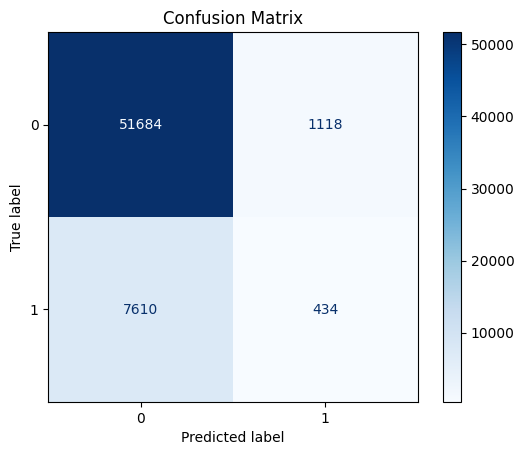

ROC AUC for Class 0: 0.4588046079222132
ROC AUC for Class 1: 0.6192148876512691
Overall ROC AUC: 0.6192148876512691


In [25]:
sgd_lr_svd_batch_9_loaded = joblib.load('00_dataset/with_stopwords/model/sgd_lr_svd/sgd_lr_svd_batch_9.joblib')
evaluate_model(sgd_lr_svd_batch_9_loaded, X_val_svd, y_val_svd)

Accuracy: 0.8677973901324656
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     52802
           1       0.50      0.01      0.02      8044

    accuracy                           0.87     60846
   macro avg       0.68      0.50      0.47     60846
weighted avg       0.82      0.87      0.81     60846



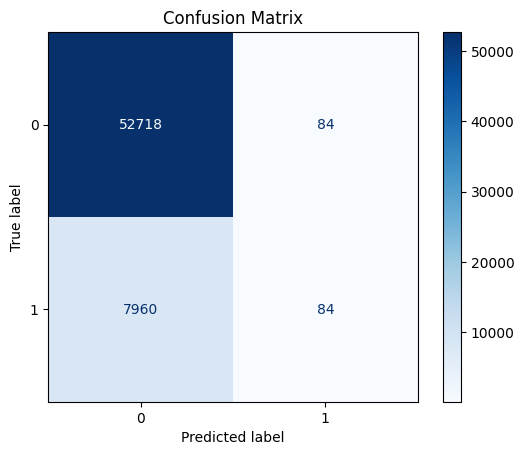

ROC AUC for Class 0: 0.2667959750876637
ROC AUC for Class 1: 0.7332040249123364
Overall ROC AUC: 0.7332040249123364


In [26]:
sgd_lr_svd_scaled_batch_9_loaded = joblib.load('00_dataset/with_stopwords/model/sgd_lr_svd_scaled/sgd_lr_svd_scaled_batch_9.joblib')
evaluate_model(trained_model_scaled, X_val_svd_scaled, y_val_svd)

Accuracy: 0.13220260986753443
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     52802
           1       0.13      1.00      0.23      8044

    accuracy                           0.13     60846
   macro avg       0.07      0.50      0.12     60846
weighted avg       0.02      0.13      0.03     60846



/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

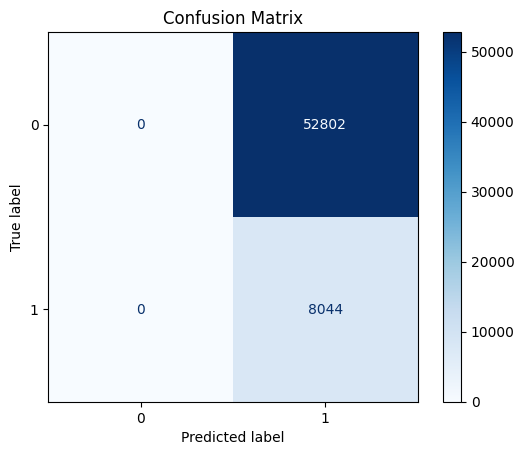

ROC AUC for Class 0: 0.5391407493247953
ROC AUC for Class 1: 0.4608592506752048
Overall ROC AUC: 0.4608592506752048


In [27]:
X_test_svd_scaled_loaded = joblib.load('00_dataset/with_stopwords/data/X_test_svd_scaled.joblib')
evaluate_model(trained_model_undersample, X_val_svd_scaled, y_val_svd)